In [0]:
#!pip3 install torch torchvision

In [0]:
#!pip3 install fastai==0.7.0

In [0]:
#!pip3 install torchtext==0.2.3

In [0]:
#from google.colab import drive

#drive.mount('/content/gdrive')

In [0]:
from fastai.text import * 

DATA_PATH = '/content/gdrive/My Drive/CS/SI/Proyecto/database/'

In [0]:
train_ids = np.load(DATA_PATH + 'ulmfit/tmp/train_lm.npy')
test_ids  = np.load(DATA_PATH + 'ulmfit/tmp/test_lm.npy')
itos      = pickle.load(open(DATA_PATH + 'ulmfit/tmp/itos.pkl', 'rb'))

In [3]:
vs=len(itos)
vs,len(train_ids)

(715, 736)

## Wikitext103

We use a transfer learning method to learn the structure of the spanish language. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(like wikipedia articles) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. Link to dataset The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: Link. Our target LM is the IMDB LM.

In [0]:
WIKITEX = DATA_PATH + 'ulmfit/'

In [0]:
#!wget -nH -r -np -P ../database/ulmfit/model/ http://files.fast.ai/models/wt103/fwd_wt103.h5

In [0]:
#!wget -nH -r -np -P ../database/ulmfit/model/ http://files.fast.ai/models/wt103/itos_wt103.pkl

In [0]:
em_sz, nh, nl = 400, 1150, 3

In [0]:
PRE_PATH    = WIKITEX  + 'models/wt103/'
PRE_LM_PATH = PRE_PATH + 'fwd_wt103.h5'

In [0]:
wgts = torch.load(str(PRE_LM_PATH), map_location=lambda storage, loc: storage)

In [0]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m    = enc_wgts.mean(0)

In [0]:
itos2 = pickle.load(open(PRE_PATH + 'itos_wt103.pkl','rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [0]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)

c1 = 0
c2 = 0
for i,w in enumerate(itos):
    r = stoi2[w]
    
    if r >= 0:
      new_w[i] = enc_wgts[r]
      c1+=1
    else:
      new_w[i] = row_m
      c2+=1

In [13]:
print('Número de palabras encontradas en el encoder    : ', c1)
print('Número de palabras no encontradas en el encoder : ', c2)

Número de palabras encontradas en el encoder    :  456
Número de palabras no encontradas en el encoder :  259


In [0]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Training A new IMDB language model

In [0]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [0]:
ULMFIT_PATH = DATA_PATH + 'ulmfit/'
TASS_PATH   = DATA_PATH + '/tass_model/'

In [0]:
trn_dl = LanguageModelLoader(np.concatenate(train_ids), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(test_ids), bs//4, bptt)
md     = LanguageModelData(TASS_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [0]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [0]:
learner= md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [0]:
learner.model.load_state_dict(wgts)

In [0]:
lr  = 1e-2
lrs = lr

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [22]:
learner.fit(lrs, 1 , wds=wd, use_clr=(32,2), cycle_len=10)

epoch      trn_loss   val_loss   accuracy   
    0      5.794668   5.757877   0.039089  
    1      5.867703   5.456882   0.053946  
    2      5.673241   5.114542   0.113563  
    3      5.49237    4.919507   0.203094  
    4      5.345495   4.882925   0.221854  
    5      5.224612   4.870755   0.199376  
    6      5.109615   4.833202   0.213745  
    7      5.012044   4.807715   0.221781  
    8      4.93055    4.792758   0.223433  
    9      4.862013   4.782744   0.223659  



[array([4.78274]), 0.22365869531611435]

In [0]:
learner.save(TASS_PATH + 'lm_last_ft')

In [0]:
learner.load(TASS_PATH + 'lm_last_ft')

In [0]:
learner.unfreeze()

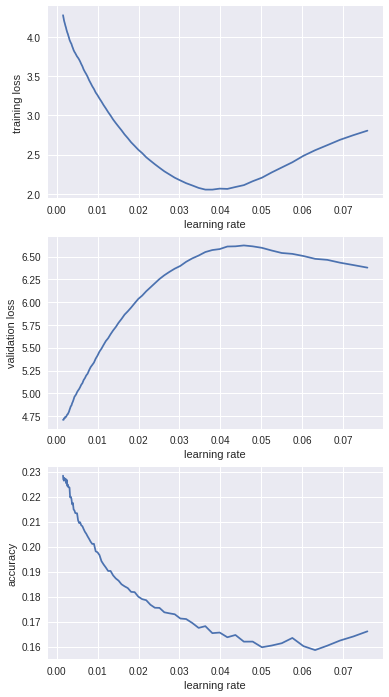

In [26]:
learner.lr_find2(start_lr=lrs/10, end_lr=lrs*10, num_it=100)
learner.sched.plot()

In [27]:
learner.fit(lrs/10, 1, wds=wd, use_clr=(20,10), cycle_len=30, best_save_name=TASS_PATH + 'lm1')

epoch      trn_loss   val_loss   accuracy   
    0      4.398858   6.162366   0.242515  
    1      4.774429   5.176517   0.084413  
    2      4.75143    6.183654   0.242338  
    3      4.892504   4.791582   0.167504  
    4      4.814917   4.677708   0.242539  
    5      4.733163   4.690414   0.224532  
    6      4.652516   4.662025   0.236994  
    7      4.576716   4.744849   0.227191  
    8      4.508265   4.789712   0.229408  
    9      4.440038   4.839679   0.229545  
    10     4.373217   4.934      0.220831  
    11     4.307525   5.023801   0.215993  
    12     4.240831   5.10902    0.195639  
    13     4.179318   5.040099   0.223841  
    14     4.111548   5.475753   0.210773  
    15     4.041824   5.31291    0.206215  
    16     3.970997   5.517832   0.195876  
    17     3.898507   5.616692   0.205196  
    18     3.82098    5.719591   0.179646  
    19     3.742105   5.837067   0.17847   
    20     3.66939    6.076741   0.194596  
    21     3.596446   6.05939  

[array([6.18341]), 0.1773007354224991]

In [0]:
#learner.save(TASS_PATH+'lm1')
#learner.save_encoder(TASS_PATH+'lm1_enc')

learner.load(TASS_PATH +'lm1')
learner.save_encoder(TASS_PATH +'lm1_enc')

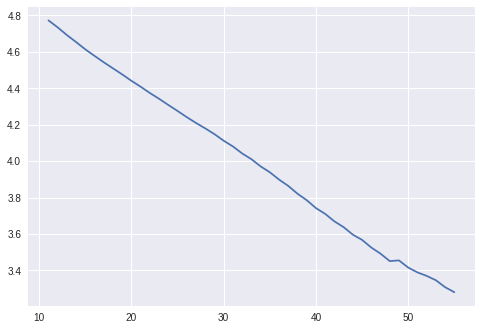

In [29]:
learner.sched.plot_loss()

## Clasifier

In [0]:
train_labels = np.squeeze(np.load(DATA_PATH + 'ulmfit/tmp/train_labels.npy'))
test_labels  = np.squeeze(np.load(DATA_PATH + 'ulmfit/tmp/test_labels.npy'))

In [0]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [32]:
min_lbl = train_labels.min()
print(min_lbl)
c=int(train_labels.max())+1
print(c == 2)

0
True


In [33]:
len(train_ids), len(train_labels), len(test_ids), len(test_labels)

(736, 736, 375, 375)

In [0]:
trn_ds   = TextDataset(train_ids, train_labels)
val_ds   = TextDataset(test_ids, test_labels)

trn_samp = SortishSampler(train_ids, key=lambda x: len(train_ids[x]), bs=bs//2)
val_samp = SortSampler(test_ids, key=lambda x: len(test_ids[x]))

trn_dl   = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl   = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

md       = ModelData(ULMFIT_PATH, trn_dl, trn_dl)

In [0]:
dps = np.array([0.4,0.5,0.05,0.3,0.1])

In [0]:
def get_rnn_classifier(bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                       dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5):
  
  rnn_enc = MultiBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                          dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
  
  return SequentialRNN(rnn_enc, PoolingLinearClassifier(layers, drops))

In [0]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [0]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [0]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip= .25
learn.metrics = [accuracy]

In [0]:
lr  = 1e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [0]:
wd = 1e-3
learn.load_encoder(TASS_PATH + 'lm1_enc')

In [0]:
learn.freeze_to(-1)

In [44]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.70513    0.674016   0.601838  


[array([0.67402]), 0.601837737470623]

In [0]:
learn.save(TASS_PATH + 'clas2_0')

In [0]:
learn.load(TASS_PATH + 'clas2_0')

In [0]:
learn.freeze_to(-2)

In [48]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   
    0      0.687288   0.670961   0.59867   


[array([0.67096]), 0.5986700511066676]

In [0]:
learn.save(TASS_PATH + 'clas2_1')

In [0]:
learn.load(TASS_PATH + 'clas2_1')

In [0]:
learn.unfreeze()

In [58]:
learn.fit(lrs*5, 1, wds=wd, cycle_len=40, use_clr=(32,10), best_save_name=TASS_PATH + 'clas2')

epoch      trn_loss   val_loss   accuracy   
    0      0.53627    0.511174   0.749259  
    1      0.558794   1.176536   0.422909  
    2      0.576526   0.449654   0.812241  
    3      0.57779    1.339003   0.5868    
    4      0.57007    0.470206   0.770571  
    5      0.55503    1.900282   0.443874  
    6      0.550846   0.41218    0.800839  
    7      0.521616   0.273318   0.898102  
    8      0.511804   0.399333   0.841888  
    9      0.492181   0.378301   0.832693  
    10     0.487898   0.48334    0.833854  
    11     0.468844   0.362321   0.840376  
    12     0.464449   0.305735   0.877404  
    13     0.43719    0.261425   0.912657  
    14     0.439512   0.47822    0.739675  
    15     0.42874    0.210226   0.937973  
    16     0.416082   0.255656   0.92677   
    17     0.391713   0.235278   0.924206  
    18     0.388203   0.321785   0.865272  
    19     0.388207   0.182314   0.934875  
    20     0.392771   0.184788   0.932995  
    21     0.38939    0.286756 

[array([0.09721]), 0.9794159508159018]

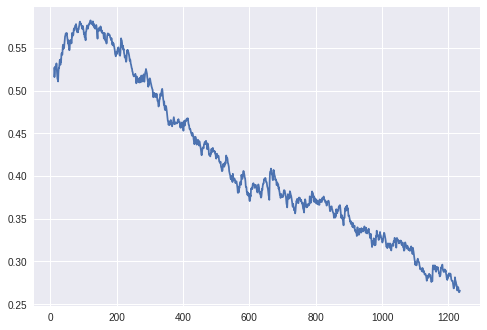

In [59]:
learn.sched.plot_loss()

In [0]:
learn2 = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn2.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn2.clip=.12
learn2.metrics = [accuracy]

learn2.load(TASS_PATH + 'clas2')
mev = learn2.model
mev[0].bs=1

In [61]:
c = 0

train_ids_f = np.copy(train_ids)

for i in range(len(train_ids_f)):
  mev.eval()
  mev.reset()
  input_seq = np.array(train_ids_f[i]).reshape(-1,1)
  p = mev(VV(input_seq))
 
  if (to_np(torch.topk(p[0],1)[1])[0][0] == train_labels[i]):
    c+=1

print('Train Accuracy = ', 100*c / len(train_ids_f))

Train Accuracy =  97.14673913043478


In [62]:
c = 0

test_ids_f = np.copy(test_ids)

for i in range(len(test_ids_f)):
  mev.eval()
  mev.reset()
  input_seq = np.array(test_ids_f[i]).reshape(-1,1)
  p = mev(VV(input_seq))
 
  if (to_np(torch.topk(p[0],1)[1])[0][0] == test_labels[i]):
    c+=1

print('Test Accuracy = ', 100*c / len(test_ids_f))

Test Accuracy =  69.6
